**<center><font size = "6">Trabajo: Evaluación de la segmentación<center>**
***

_Percepción Computacional - Curso 2022/2023_
* Agatiello, Agustina - agustina.agatiello882@comunidadunir.net
* Giraldo Pérez, Edison Jose - edisonjose.giraldo261@comunidadunir.net
* Orellana Martínez, Joel Elí - joel.orellana102@comunidadunir.net
***

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, IntSlider
from sklearn.metrics import f1_score

## 1. Carga de imagen

### 1.1. Imagen original

In [2]:
img = cv2.imread('radiografia.png', 0)

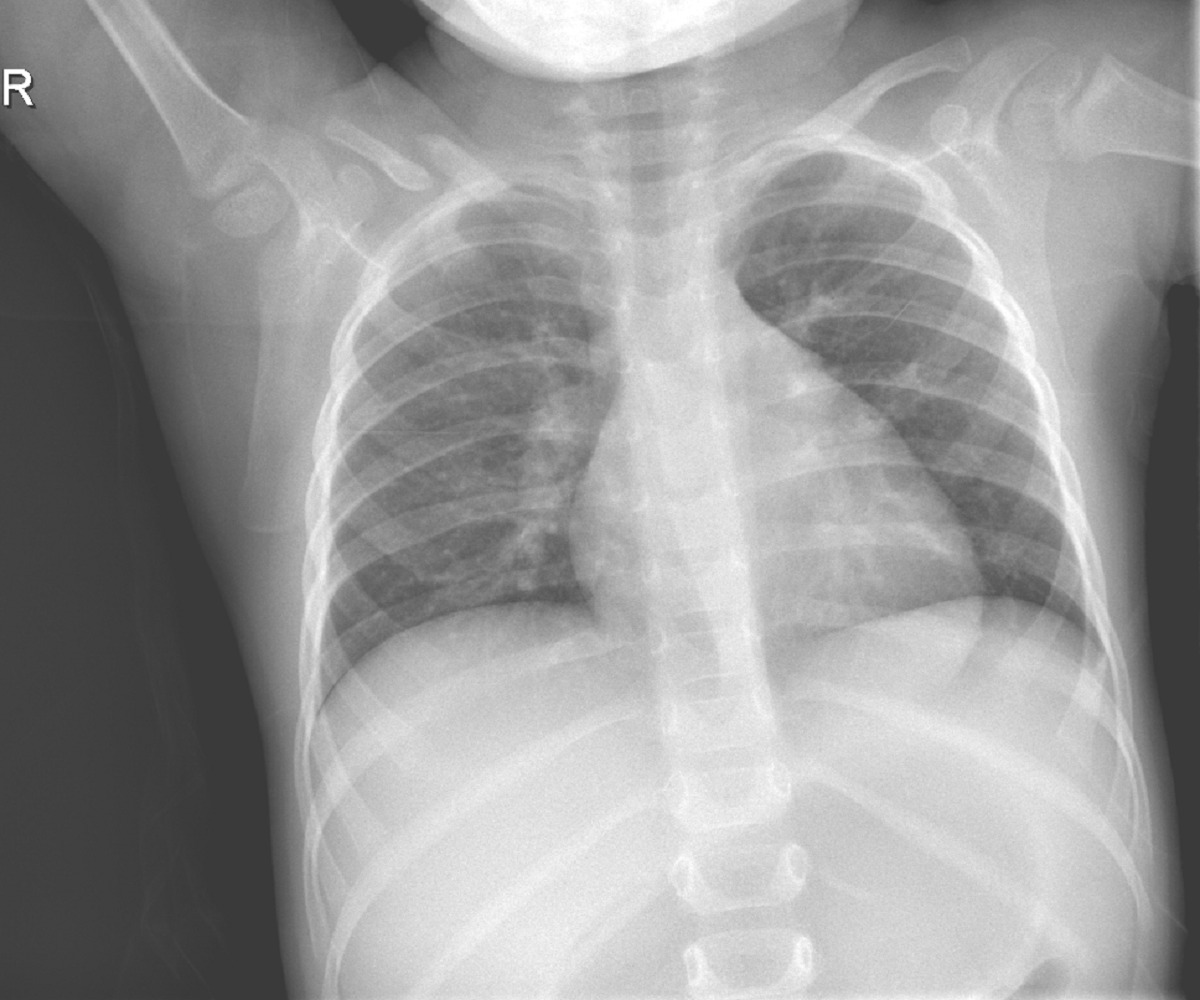

In [3]:
retval, buffer = cv2.imencode('.png', img)
data = buffer.tobytes()
Image(data=data)

### 1.2. Ground truth 

In [4]:
ground_truth = cv2.imread('ground_truth.png', 0)

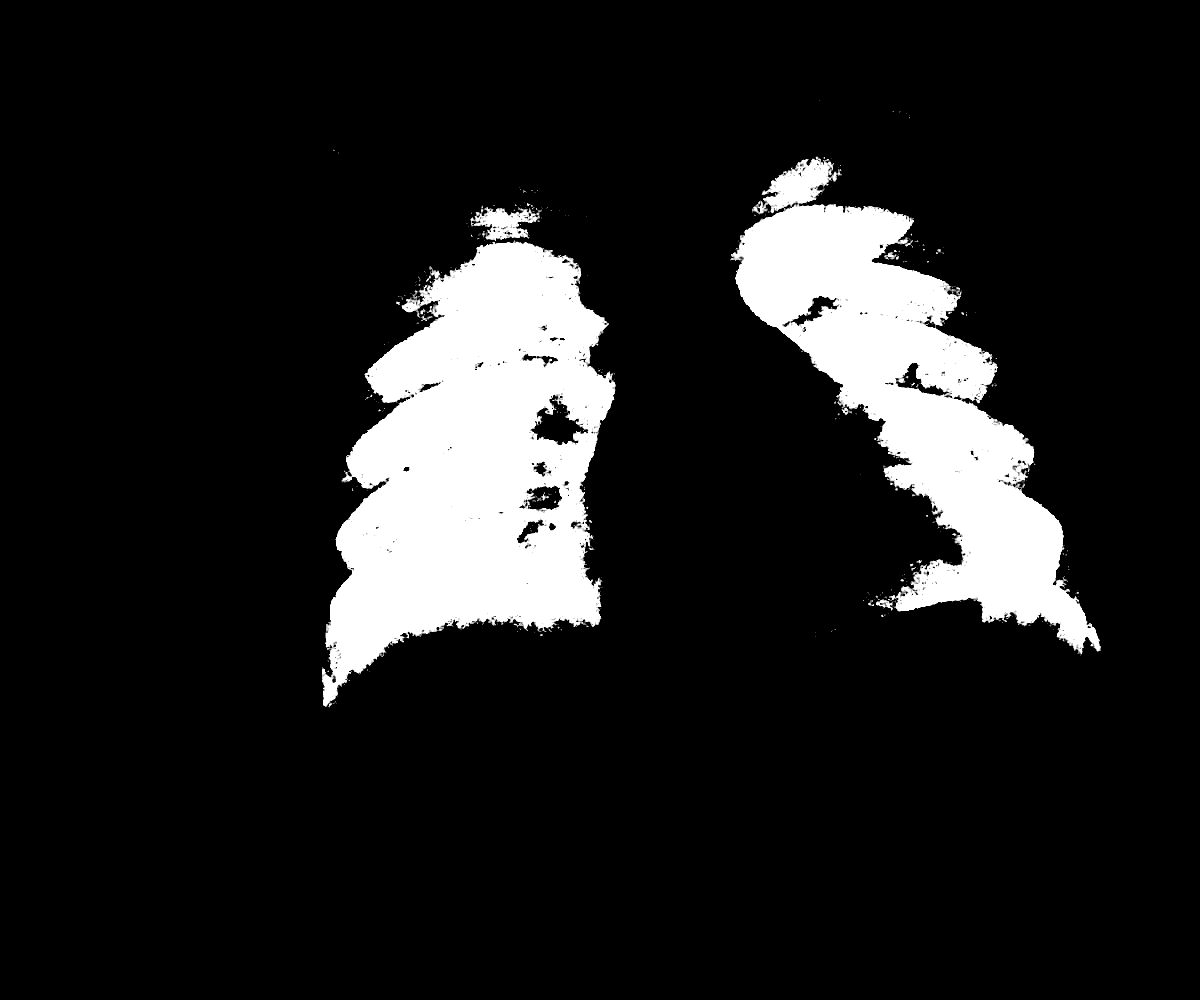

In [5]:
retval, buffer = cv2.imencode('.png', ground_truth)
data = buffer.tobytes()
Image(data=data)

## 2. Segmentaciones

### 2.1. Segmentación mediante umbralización global interactiva

Este segmentador permite al usuario seleccionar un umbral global para separar los huesos del fondo mediante una herramienta interactiva.

In [6]:
# Función para segmentar la imagen
def threshold_image(img, thres_val):
    _, dst = cv2.threshold(img, thres_val, 255, cv2.THRESH_BINARY)
    return dst

# Función de callback para la selección del umbral
def threshold_callback(thres_val):
    global img
    dst = threshold_image(img, thres_val)
    show_image(dst, 'Imagen segmentada')
    cv2.imwrite('seg_1.png', dst)

# Función para mostrar la imagen segmentada en el notebook
def show_image(img, title=''):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()
    
# Crear barra deslizante para seleccionar el umbral
umbral_slider = widgets.IntSlider(
    value=140,
    min=0,
    max=255,
    step=1,
    description='Umbral:',
    continuous_update=False
)

# Crear interfaz interactiva para mostrar la imagen segmentada
interactive_output = widgets.interactive_output(
    threshold_callback, {'thres_val': umbral_slider})
images_box = widgets.HBox([widgets.Output(), widgets.Output()])

# Mostrar la imagen original y la imagen segmentada
with images_box.children[0]:
    show_image(img, 'Imagen original')
with images_box.children[1]:
    display(widgets.VBox([umbral_slider, interactive_output]))

display(images_box)

### 2.2. Segmentación mediante umbralización adaptativa 

Este código define una función adaptive_thresholding() que toma tres argumentos: threshold_value, block_size y constant, que corresponden al valor del umbral, el tamaño de bloque y el valor constante para la umbralización adaptativa, respectivamente.

Luego, se crea una barra deslizante threshold_slider para el valor del umbral, y se define un control interactivo interactive_obj que llama a la función adaptive_thresholding() con los valores actuales de la barra deslizante y los otros parámetros.

Finalmente, se muestra el control interactivo dentro del notebook mediante la función display(). Cuando se cambia el valor de la barra deslizante, se llama a la función adaptive_thresholding() con los nuevos parámetros y se muestra la imagen original y la imagen segmentada en tiempo real dentro del notebook.

In [7]:
# Función de segmentación adaptativa
def adaptive_thresholding(threshold_value, block_size, constant):
    global img
    thres_adapt = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, constant)

    # Mostrar imágenes
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Imagen original')
    ax[1].imshow(thres_adapt, cmap='gray')
    ax[1].set_title('Imagen segmentada')
    plt.show()

    # Guardar la imagen segmentada
    cv2.imwrite('seg_2.png', thres_adapt)

# Crear barra deslizante
threshold_slider = IntSlider(min=1, max=255, value=127, description='Umbral')

# Crear control interactivo
interactive_obj = interactive(adaptive_thresholding,
                              threshold_value=threshold_slider,
                              block_size=(3, 51, 2),
                              constant=(-10, 10))

# Mostrar control interactivo
display(interactive_obj)

interactive(children=(IntSlider(value=127, description='Umbral', max=255, min=1), IntSlider(value=27, descript…

### 2.3. Segmentación mediante detección de bordes interactiva

Este segmentador permite al usuario seleccionar los bordes de los huesos mediante una herramienta interactiva, y luego aplica un umbral para separar los huesos del fondo. Conocido como filtro de Canny.

In [8]:
# Función para segmentar la imagen mediante detección de bordes
def canny_segmentation(img, x):
    edges = cv2.Canny(img, x / 2, x)
    _, dst = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return dst

# Función de callback para la selección de bordes
def canny_callback(thres_val):
    dst = canny_segmentation(img, thres_val)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Imagen Original')
    ax1.axis('off')
    ax2.imshow(dst, cmap='gray')
    ax2.set_title('Imagen Segmentada')
    ax2.axis('off')
    plt.show()
    cv2.imwrite('seg_3.png', dst)

# Crear barra deslizante para seleccionar el umbral
umbral_slider = widgets.IntSlider(
    value=72,
    min=0,
    max=500,
    step=1,
    description='Umbral:',
    continuous_update=False
)

# Crear interfaz interactiva para mostrar la imagen segmentada
interactive_output = widgets.interactive_output(
    canny_callback, {'thres_val': umbral_slider})
display(widgets.VBox([umbral_slider, interactive_output]))

### 2.4. Segmentación mediante detección de bordes basada en el operador Sobel

Este segmentador detecta los bordes de los huesos mediante el operador Sobel y luego aplica un umbral para separar los huesos del fondo.

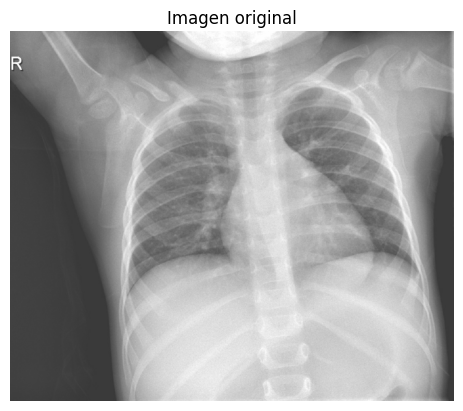

In [9]:
# Función para segmentar la imagen
def sobel_threshold(img, thres_val):
    # Aplicar operador Sobel en dirección x
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    abs_sobelx = np.absolute(sobelx)
    sobelx_8u = np.uint8(abs_sobelx * 255 / np.max(abs_sobelx))

    # Aplicar umbralización
    _, dst = cv2.threshold(sobelx_8u, thres_val, 255, cv2.THRESH_BINARY)

    return dst


# Función para mostrar la imagen segmentada en el notebook
def show_image(img, title):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(title)
    plt.show()


# Función de callback para la selección del umbral
def sobel_callback(thres_val):
    dst = sobel_threshold(img, thres_val)
    show_image(dst, "Imagen segmentada")
    cv2.imwrite('seg_4.png', dst)

# Crear barra deslizante para seleccionar el umbral
umbral_slider = widgets.IntSlider(
    value=4,
    min=0,
    max=255,
    step=1,
    description='Umbral:',
    continuous_update=False
)

# Crear interfaz interactiva para mostrar la imagen segmentada
interactive_output = widgets.interactive_output(
    sobel_callback, {'thres_val': umbral_slider})
display(widgets.VBox([interactive_output, umbral_slider]))

# Mostrar la imagen original
show_image(img, "Imagen original")

### 2.5. Segmentación mediante la transformada de Hough

Este segmentador detecta líneas en la imagen mediante la transformada de Hough y luego las utiliza para separar los huesos del fondo.

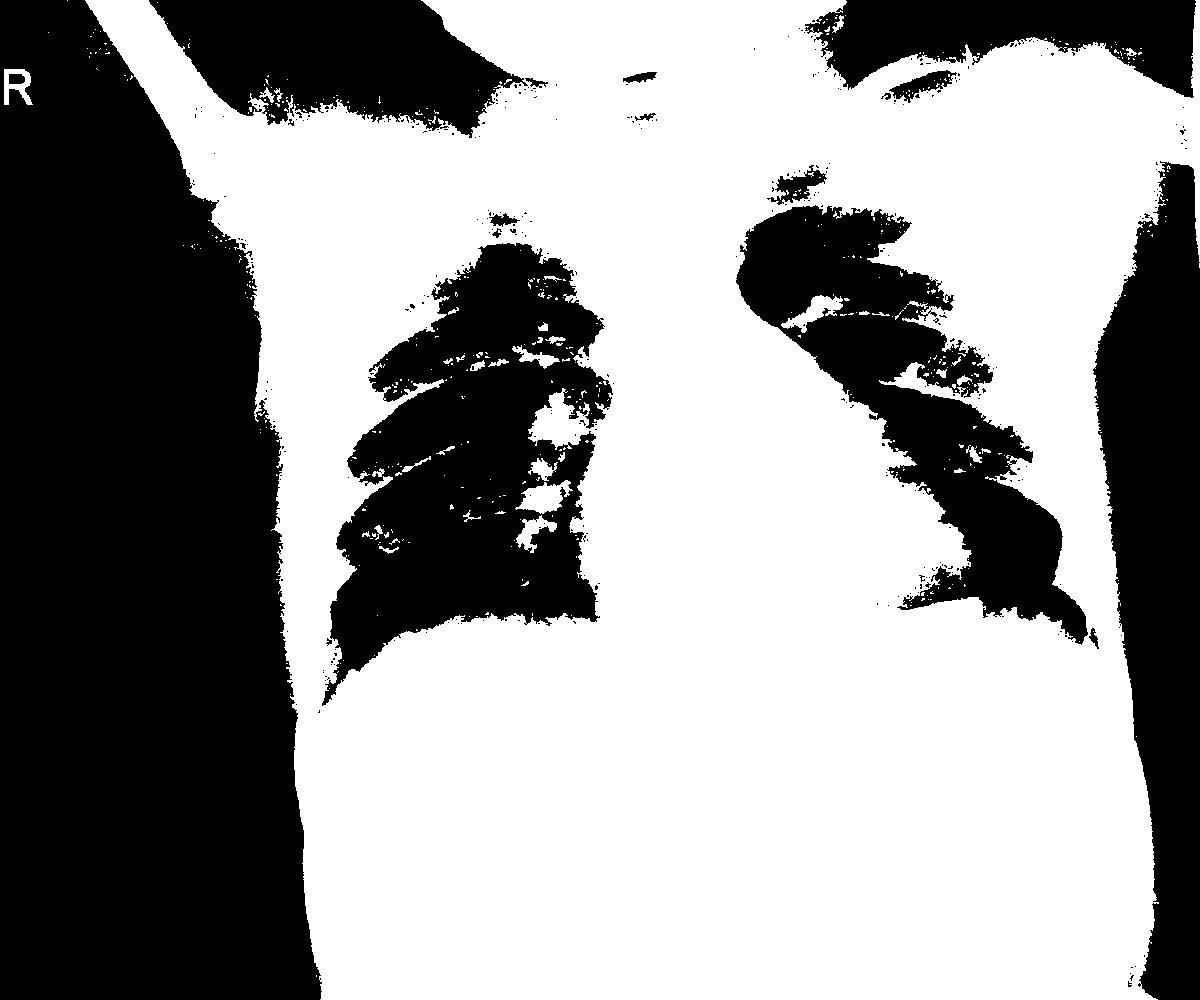

In [10]:
# Aplicar umbralización
_, hough = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Detectar líneas mediante la transformada de Hough
lines = cv2.HoughLines(hough, 1, np.pi / 180, 150)

# Dibujar líneas en la imagen original
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Guardar imagen segmentada
cv2.imwrite('seg_5.png', hough)

# Mostrar imagen segmentada
retval, buffer = cv2.imencode('.png', hough)
data = buffer.tobytes()
Image(data=data)

## 3. Evaluación del rendimiento individual de cada técnica de segmentación

In [11]:
# Aplicar la segmentación mediante umbralización global interactiva
threshold, segmented = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Calcular la precisión, la sensibilidad y la especificidad
tp = np.sum(np.logical_and(segmented, ground_truth))
fp = np.sum(np.logical_and(segmented, np.logical_not(ground_truth)))
tn = np.sum(np.logical_and(np.logical_not(segmented), np.logical_not(ground_truth)))
fn = np.sum(np.logical_and(np.logical_not(segmented), ground_truth))

precision = tp / (tp + fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Mostrar los resultados
print('Precisión:', precision)
print('Sensibilidad:', sensitivity)
print('Especificidad:', specificity)

Precisión: 0.12505147597955021
Sensibilidad: 1.0
Especificidad: 0.005014291874048755


In [12]:
# Aplicar la segmentación mediante umbralización adaptativa
segmented = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# Calcular la precisión, la sensibilidad y la especificidad
tp = np.sum(np.logical_and(segmented, ground_truth))
fp = np.sum(np.logical_and(segmented, np.logical_not(ground_truth)))
tn = np.sum(np.logical_and(np.logical_not(segmented), np.logical_not(ground_truth)))
fn = np.sum(np.logical_and(np.logical_not(segmented), ground_truth))

precision = tp / (tp + fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Mostrar los resultados
print('Precisión:', precision)
print('Sensibilidad:', sensitivity)
print('Especificidad:', specificity)

Precisión: 0.0
Sensibilidad: 0.0
Especificidad: 0.9972339536473072


In [13]:
# Aplicar la segmentación mediante detección de bordes interactiva
edges = cv2.Canny(img, 100, 200)
segmented = cv2.bitwise_not(edges)

# Calcular la precisión, la sensibilidad y la especificidad
tp = np.sum(np.logical_and(segmented, ground_truth))
fp = np.sum(np.logical_and(segmented, np.logical_not(ground_truth)))
tn = np.sum(np.logical_and(np.logical_not(segmented), np.logical_not(ground_truth)))
fn = np.sum(np.logical_and(np.logical_not(segmented), ground_truth))

precision = tp / (tp + fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Mostrar los resultados
print('Precisión:', precision)
print('Sensibilidad:', sensitivity)
print('Especificidad:', specificity)

Precisión: 0.12454775235002051
Sensibilidad: 1.0
Especificidad: 0.00041500213688026904


In [14]:
# Aplicar la segmentación mediante detección de bordes basada en el operador Sobel
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))
magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
_, segmented = cv2.threshold(magnitude, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Calcular la precisión, la sensibilidad y la especificidad
tp = np.sum(np.logical_and(segmented, ground_truth))
fp = np.sum(np.logical_and(segmented, np.logical_not(ground_truth)))
tn = np.sum(np.logical_and(np.logical_not(segmented), np.logical_not(ground_truth)))
fn = np.sum(np.logical_and(np.logical_not(segmented), ground_truth))

precision = tp / (tp + fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Mostrar los resultados
print('Precisión:', precision)
print('Sensibilidad:', sensitivity)
print('Especificidad:', specificity)

Precisión: 0.1245860764929807
Sensibilidad: 1.0
Especificidad: 0.0007662310096069187


In [15]:
# Aplicar la segmentación mediante la transformada de Hough
edges = cv2.Canny(img, 50, 150, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi/180, 100)
segmented = np.zeros_like(img)
if lines is not None:
    for rho, theta in lines[:, 0, :]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(segmented, (x1, y1), (x2, y2), (255, 255, 255), 1)

# Calcular la precisión, la sensibilidad y la especificidad
tp = np.sum(np.logical_and(segmented, ground_truth))
fp = np.sum(np.logical_and(segmented, np.logical_not(ground_truth)))
tn = np.sum(np.logical_and(np.logical_not(segmented), np.logical_not(ground_truth)))
fn = np.sum(np.logical_and(np.logical_not(segmented), ground_truth))

precision = tp / (tp + fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Mostrar los resultados
print('Precisión:', precision)
print('Sensibilidad:', sensitivity)
print('Especificidad:', specificity)

Precisión: 0.0
Sensibilidad: 0.0
Especificidad: 0.9998848273886181


## 4. Agregación de los resultados por votación

Cargar las imágenes segmentadas y almacenarlas en una lista. 

In [16]:
seg_1 = cv2.imread('seg_1.png')
seg_2 = cv2.imread('seg_2.png')
seg_3 = cv2.imread('seg_3.png')
seg_4 = cv2.imread('seg_4.png')
seg_5 = cv2.imread('seg_5.png')

In [17]:
print(seg_1.shape)
print(seg_2.shape)
print(seg_3.shape)
print(seg_4.shape)
print(seg_5.shape)

(1000, 1200, 3)
(1000, 1200, 3)
(1000, 1200, 3)
(1000, 1200, 3)
(1000, 1200, 3)


In [18]:
segmented_images = [seg_1, seg_2, seg_3, seg_4, seg_5]

Convertir las imágenes en matrices binarias (0 o 1) donde los valores 1 representan los píxeles segmentados. Primero convertimos cada imagen a escala de grises y luego aplicamos un umbral para obtener una imagen binaria.

In [19]:
threshold_value = 127

binary_images = []
for image in segmented_images:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, threshold_value, 1, cv2.THRESH_BINARY)
    binary_images.append(binary)

Sumamos las matrices binarias de todas las imágenes y luego aplicamos otro umbral para obtener la imagen final segmentada. En la matriz final, los valores 1 representan los píxeles segmentados en al menos la mitad de las imágenes.

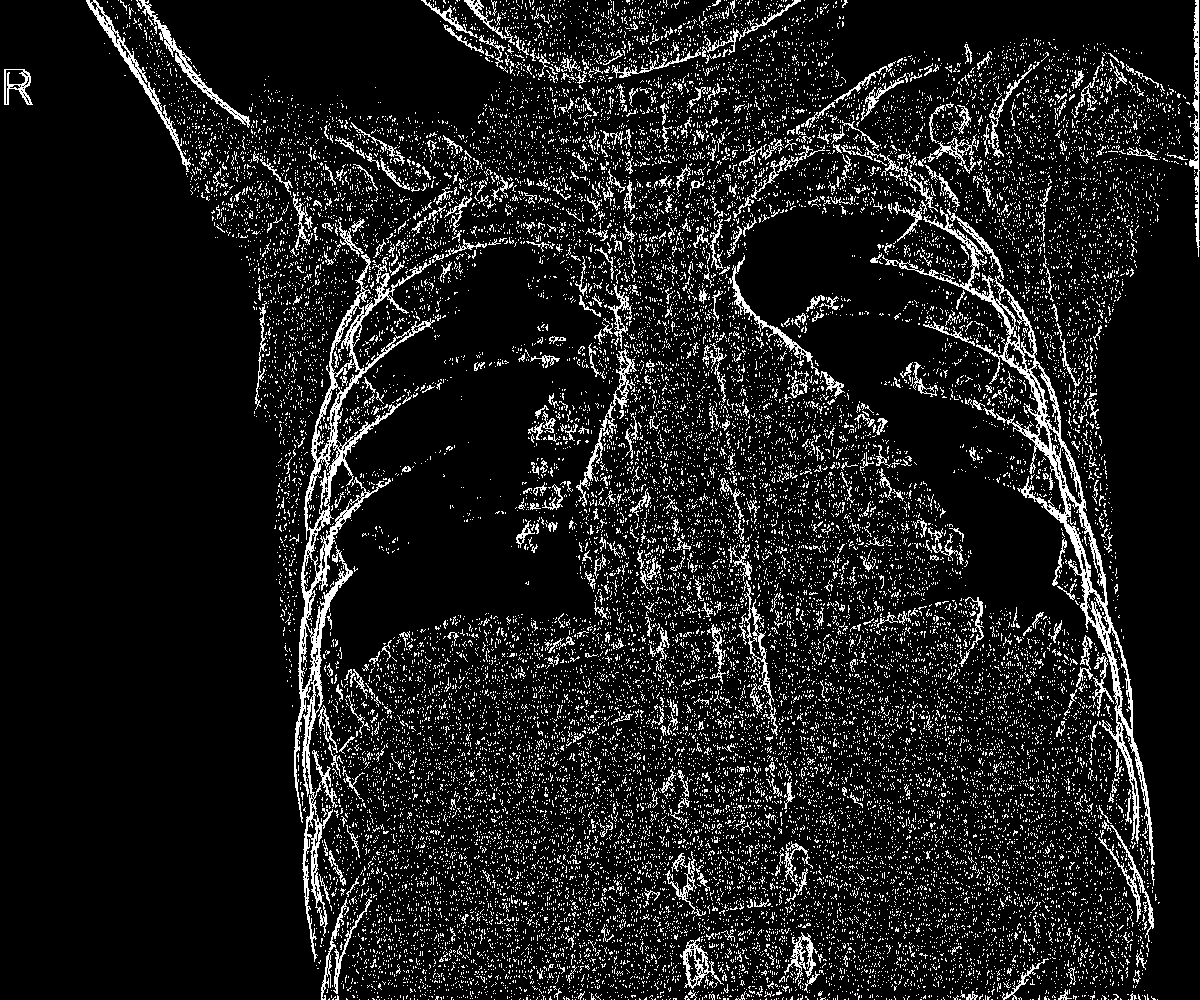

In [20]:
# Sumar las matrices binarias de todas las imágenes
threshold_votes = len(segmented_images) // 2 + 1
summed_binary = sum(binary_images)

# Aplicar el umbral para obtener la imagen final segmentada
_, final_segmented_image = cv2.threshold(
    summed_binary, threshold_votes, 255, cv2.THRESH_BINARY)

# Codificar la imagen final segmentada en PNG e imprimirla
retval, buffer = cv2.imencode('.png', final_segmented_image)
data = buffer.tobytes()
Image(data=data)